In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision as tv
import tqdm
from collections import namedtuple
from scipy.optimize import Bounds, minimize
from torch.utils.data import Dataset

In [2]:
Config = namedtuple(
    "Config",
    (
        "batch_size",
        "epochs",
        "lr",
        "lr_gamma",
        "input_size",
        "output_size",
        "w_decay",
        "r_weight",
        "device",
        "load_model01",
        "model01_path",
        "load_model02",
        "model02_path",
    )
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = Config(
    batch_size=64,
    epochs=25,
    lr=1e-4,
    lr_gamma=0.88,
    input_size=28*28,
    output_size=10,
    w_decay=1e-4,
    r_weight=0.15,
    device=device,
    load_model01=True,
    model01_path="./data/model_1.pt",
    load_model02=True,
    model02_path="./data/model_2.pt",
)

In [3]:
os.makedirs("./data", exist_ok=True)
# MNIST Datasets
train_ds = tv.datasets.MNIST(
    "./data",
    transform=tv.transforms.ToTensor(),
    train=True,
    download=True
)
test_ds = tv.datasets.MNIST(
    "./data",
    transform=tv.transforms.ToTensor(),
    train=False,
)
# MNIST Data Loaders
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=config.batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=4,
)
test_dl = torch.utils.data.DataLoader(
    test_ds,
    batch_size=config.batch_size,
    shuffle=True
)

In [4]:
def logits_to_label(logits):
    return torch.softmax(logits, 1).argmax(1)


class FCNet100(nn.Module):
    def __init__(self, config):
        super(FCNet100, self).__init__()
        self.config = config
        self.model = nn.Sequential(
            nn.Linear(config.input_size, 100),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(100, 100),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(100, config.output_size),
        )
    
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x).to(self.config.device)
        x = x.view(x.size(0), self.config.input_size)
        # Logits
        return self.model(x)

In [5]:
def train(model, opt, loss_func, loader, config, epoch):
    it = tqdm.tqdm(loader, ncols=80, desc=f"train: {epoch + 1}/{config.epochs}")
    for imgs, targets in it:
        model.train()
        opt.zero_grad()
        imgs = imgs.to(config.device).double()
        targets = targets.to(config.device)
        out = model(imgs)
        loss = loss_func(out, targets)
        loss.backward()
        opt.step()
        
        
def test(model, loader, config):
    correct = 0
    for imgs, targets in tqdm.tqdm(loader, ncols=80, desc="Test"):
        model.eval()
        imgs = imgs.to(config.device).double()
        targets = targets.to(config.device)
        with torch.no_grad():
            out = model(imgs)
            pred = logits_to_label(out)
            correct += (pred == targets).sum()
    N = len(loader.dataset)
    acc = float(correct) / N
    print(f"Test acc: {acc:.02%}")

    
def fetch_trained_model(model_class, train_loader, test_loader, load_from_file, path, config):
    """Either fetch a stored model from disc or train one from scratch"""
    model = model_class(config).double().to(config.device)
    if os.path.isfile(path) and load_from_file:
        model.load_state_dict(torch.load(path))
        test(model, test_loader, config)
    else:
        opt = torch.optim.Adam(model.parameters(), config.lr, weight_decay=config.w_decay)
        # Learning rate adjuster
        sched = torch.optim.lr_scheduler.StepLR(opt, 1, config.lr_gamma)
        criterion = nn.CrossEntropyLoss()

        for ep in range(config.epochs):
            train(model, opt, criterion, train_loader, config, ep)
            test(model, test_loader, config)
            sched.step()
        torch.save(model.state_dict(), path)
    model.eval()
    print(model)
    return model

In [6]:
model = fetch_trained_model(
    FCNet100, train_dl,
    test_dl,
    config.load_model01,
    config.model01_path,
    config
)

Test: 100%|██████████████████████████████████| 157/157 [00:00<00:00, 166.16it/s]

Test acc: 94.44%
FCNet100(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [7]:
def adv_penalty_func(xr, *args):
    """This is simply the equation from Section 4.1"""
    x, net, c, target, device = args
    # |r| penalty portion
    size_penalty = c * np.abs(x - xr).sum()
    # x + r as a tensor
    xrt = torch.tensor(xr.reshape(1, 28, 28)).to(device)
    # loss_f(x + r, l) penalty
    logits = net(xrt)
    class_penalty = nn.functional.cross_entropy(logits, target).item()
    return size_penalty + class_penalty


def find_adversarial_example(net, x, target, config):
    """This is the optimization problem described in Section 4.1"""
    # The c weight for the L1 norm of r
    c = config.r_weight
    # Box constraint: [0, 1]^m
    box_constraint = Bounds(np.zeros_like(x.ravel()), np.ones_like(x.ravel()))
    # Target label
    target = torch.tensor([target]).to(config.device, dtype=torch.int64)
    # Args in addition to the (x + r) array that are used by the penalty function
    args = (x.flatten(), net, c, target, device)
    # Use x as initial guess for (x + r)
    xr0 = x.copy()
    with torch.no_grad():
        res = minimize(
            adv_penalty_func,
            # Flatten it since minimize only works on a 1D array
            xr0.flatten(),
            args,
            method='L-BFGS-B',
            jac=None,
            bounds=box_constraint,
            tol=None,
            callback=None,
            options={
                'disp': None,
                'maxcor': 10,
                'ftol': 2.220446049250313e-09,
                'gtol': 1e-05,
                'eps': 1e-09,
                'maxfun': 45000,
                'maxiter': 45000,
                'iprint': -1,
                'maxls': 30
            }
        )
    # Reshape back into an image
    xr = torch.tensor(res.x.reshape(x.shape))
    return xr

[[7 2 1 0]
 [4 1 4 9]
 [9 0 6 9]
 [0 1 5 9]]


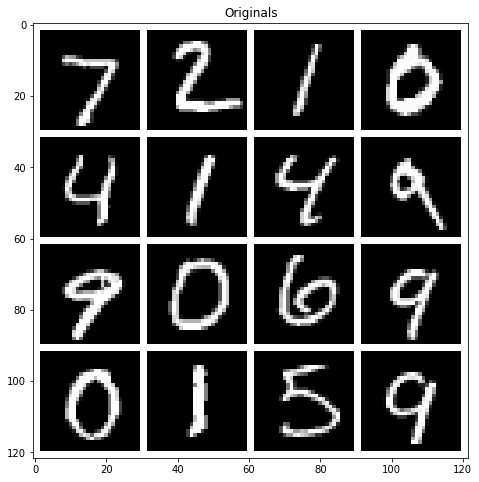

In [8]:
# Select N images that the model correctly classifies already
N = 16
adv_target = 3
x_imgs = []
x_labels = []
for x, label in test_ds:
    if label == adv_target:
        continue
    x = x.to(config.device).double()
    if (logits_to_label(model(x)) == label).item():
        # Make sure that the model correctly classifies this x
        x_imgs.append(x.cpu())
        x_labels.append(label)
    if len(x_imgs) >= N:
        break
x_labels = np.array(x_labels).reshape(4, 4)
grid = tv.utils.make_grid(x_imgs, nrow=4, pad_value=1)
plt.figure(figsize=(8, 8))
plt.title("Originals")
plt.imshow(np.transpose(grid, (1, 2, 0)))
print(x_labels)

In [9]:
xr_imgs = []
xr_labels = []
for x in tqdm.tqdm(x_imgs, ncols=80):
    xr = find_adversarial_example(model, x.numpy(), adv_target, config)
    xr_imgs.append(xr)
    new_label = logits_to_label(model(xr.to(config.device))).item()
    xr_labels.append(new_label)
xr_labels = np.array(xr_labels).reshape(4, 4)

100%|███████████████████████████████████████████| 16/16 [03:06<00:00, 11.66s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


New Labels:
[[3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]]


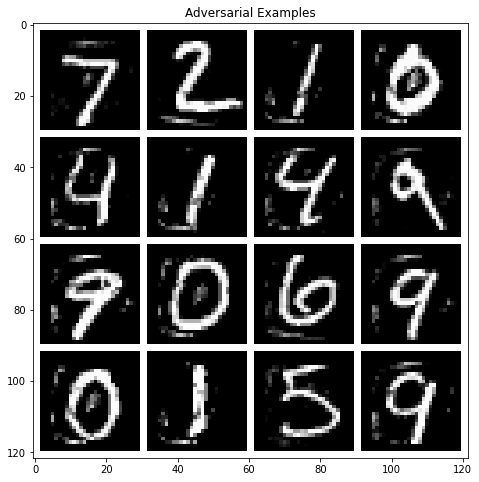

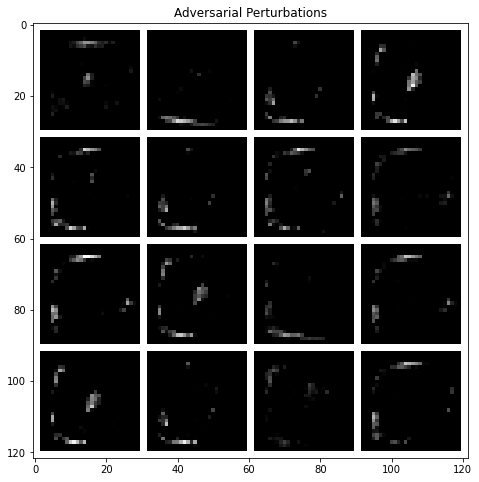

In [10]:
grid = tv.utils.make_grid(xr_imgs, nrow=4, pad_value=1)
plt.figure(figsize=(8, 8))
plt.title("Adversarial Examples")
plt.imshow(np.transpose(grid, (1, 2, 0)))
print(f"New Labels:\n{xr_labels}")

r_imgs = [xr - x for xr, x in zip(xr_imgs, x_imgs)]
grid = tv.utils.make_grid(r_imgs, nrow=4, pad_value=1)
plt.figure(figsize=(8, 8))
plt.title("Adversarial Perturbations")
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [11]:
class FCNet200(nn.Module):
    def __init__(self, config):
        super(FCNet200, self).__init__()
        self.config = config
        self.model = nn.Sequential(
            nn.Linear(config.input_size, 200),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(200, 200),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Linear(200, config.output_size),
        )
    
    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x).to(self.config.device)
        x = x.view(x.size(0), self.config.input_size)
        # Logits
        return self.model(x)

In [12]:
model2 = FCNet200(config).double().to(config.device)
model2 = fetch_trained_model(
    FCNet200, train_dl,
    test_dl,
    config.load_model02,
    config.model02_path,
    config
)

Test: 100%|██████████████████████████████████| 157/157 [00:00<00:00, 193.16it/s]

Test acc: 95.89%
FCNet200(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)


In [13]:
cross_model_labels = []
for xr in xr_imgs:
    label = logits_to_label(model2(xr.to(config.device))).item()
    cross_model_labels.append(label)
cross_model_labels = np.array(cross_model_labels).reshape(4, 4)
print(f"Cross Model Adverserial Labels:\n{cross_model_labels}")

Cross Model Adverserial Labels:
[[3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]]
